# Foundations of deep learning - HW1
Omer Koren & Edan Zwick

In [20]:
import part1
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix
from numpy.random import default_rng
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## ***Part 1 - Setup and baseline***

We will begin with downloading the datasets, and getting baseline results using SVM classification.First step is downloading the CIFAR dataset. We will only use a subsample, but we will download the whole set and later sample out the actual train and test sets.

In [21]:
fullTrain = torchvision.datasets.CIFAR10('datasets/CIFAR', train=True, transform=np.array, target_transform=None, download=True)
fullTest  = torchvision.datasets.CIFAR10('datasets/CIFAR', train=False, transform=np.array, target_transform=None, download=True)

Files already downloaded and verified
Files already downloaded and verified


We will now create random masks to represent the chosen subset we will use:

In [22]:
rng = default_rng(42) # keeping dataset consistent
trainMask = rng.choice(len(fullTrain), len(fullTrain)//10, replace=False)
testMask =  rng.choice(len(fullTest), len(fullTest)//10, replace=False)

Narrowing the datasets that we will use:

In [23]:
trainData   = fullTrain.data[trainMask]
trainLabels = np.array(fullTrain.targets)[trainMask]
testData    = fullTest.data[testMask]
testLabels  = np.array(fullTest.targets)[testMask]
print('Dataset shapes: Train - {}, Test - {}'.format(trainData.shape,testData.shape))

Dataset shapes: Train - (5000, 32, 32, 3), Test - (1000, 32, 32, 3)


Flattening out the tensors:

In [24]:
trainData = trainData.reshape(trainData.shape[0],-1)
testData  = testData.reshape(testData.shape[0],-1)
print('Dataset shapes: Train - {}, Test - {}'.format(trainData.shape,testData.shape))

Dataset shapes: Train - (5000, 3072), Test - (1000, 3072)


Now lets get down to buisness, train and evaluate the SVM baseline model.
To get a reasonable result we will use a grid search to find the best parameters for the regularization constant and the Gamma paramater for the RBF kernel. As this is a lengthy process, the defult option in this notebook is to run with the optimal values we already found.

In [30]:
crossValidate = False

starting with the vanila linear SVM:

In [47]:
if crossValidate:
    params = part1.cross_validate(trainData, trainLabels, 'linear')
    C = params['C']
    print('paramaters chosen for the svm model: {}'.format(params))
else:
    C = 1e-07
linearModel = svm.SVC(C,'linear')
linearModel.fit(trainData, trainLabels)
print('done')

done


Linear svm accuracy on test set:0.398
confusion matrix:


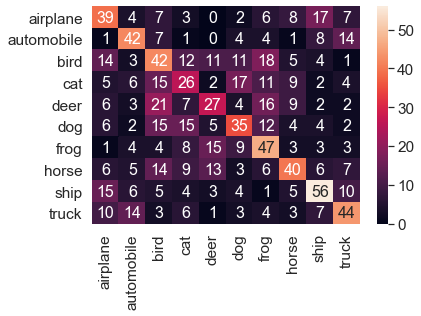

In [48]:
prediction = linearModel.predict(testData)
score = accuracy_score(testLabels, prediction)
print('Linear svm accuracy on test set:{}'.format(score))
print('confusion matrix:')
part1.confusion(testLabels, prediction, fullTrain.classes)

RBF kernel:

In [73]:
if crossValidate:
    params = part1.cross_validate(trainData, trainLabels, 'rbf')
    C = params['C']
    gamma = params['gamma']
    print('paramaters chosen for the svm model: {}'.format(params))
else:
    C = 100
    gamma = 8.32e-08
rbfModel = svm.SVC(C, kernel='rbf', gamma=gamma)
rbfModel.fit(trainData, trainLabels)
print('done')

done


In [ ]:
prediction = rbfModel.predict(testData)
score = accuracy_score(testLabels, prediction)
print('Linear svm accuracy on test set:{}'.format(score))
print('confusion matrix:')
part1.confusion(testLabels, prediction, fullTrain.classes)

## ***Part 2 - Feed Forward Neural Network***


In this section we need to implement using low-level API's, a feed forward fully connected NN.
We chose to use pyTorch as our framework.
First thing we need to do is to transform the data so that it will be easy to manipulate. This includes:
- Flattening images.
- Adding constant 1 dimention to replace bias in FC layers.
- Transforming Images to tensors.

In [69]:
t = []
t.append(torchvision.transforms.ToTensor)
t.append(torchvision.transforms.Lambda(lambda x: x.flatten()))
transforms = torchvision.transforms.Compose(t)

In [70]:
fullTrain = torchvision.datasets.CIFAR10('datasets/CIFAR', train=True, transform=torchvision.transforms.Compose(t), target_transform=None, download=True)
fullTest  = torchvision.datasets.CIFAR10('datasets/CIFAR', train=False, transform=torchvision.transforms.Compose(t), target_transform=None, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=256 ,sampler = sampler1, shuffle=True, num_workers=4)